# Steps:

1. Custom CNN for Feature Extraction
2. Texture Analysis using GLCM
3. Saving Features to CSV
4. Training an ANN Model
5. Model Evaluation Function

In [1]:
# libs
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.feature import greycomatrix, greycoprops

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Step 1: Custom CNN Model for Feature Extraction
def create_custom_cnn(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    
    model = models.Model(inputs, x)
    
    return model

In [3]:
# Step 2: Function to calculate GLCM properties
def calculate_glcm_features(image, distances, angles):
    properties = ['contrast', 'dissimilarity', 'homogeneity', 
                  'energy', 'correlation', 'ASM']
    glcm = greycomatrix(image, 
                        distances = distances, 
                        angles = angles, 
                        symmetric = True, 
                        normed = True)
    feature_vector = []
    
    for prop in properties:
        prop_values = greycoprops(glcm, prop)
        feature_vector.extend(prop_values.flatten())
    
    return feature_vector

In [4]:
# Step 3: Fetch CNN features, GLCM features, and save to CSV
def extract_features_and_save(images, labels, cnn_model, output_csv, distances, angles):
    feature_list = []
    for i, image in enumerate(images):
        print(f"Processing image {i+1}/{len(images)}")
        
        # CNN Features
        image_expanded = np.expand_dims(image, axis=0)  # Expand dimensions for the CNN model
        cnn_features = cnn_model.predict(image_expanded).flatten()
        
        # GLCM Features
        image_gray = np.mean(image, axis=-1).astype(np.uint8)  # Convert to grayscale if needed
        glcm_features = calculate_glcm_features(image_gray, distances, angles)
        
        # Combine CNN + GLCM features
        combined_features = np.concatenate([cnn_features, glcm_features])
        feature_list.append(np.concatenate([combined_features, [labels[i]]]))
    
    # Create a DataFrame and save to CSV
    df = pd.DataFrame(feature_list)
    df.to_csv(output_csv, index=False)
    print(f"Features saved to {output_csv}")

In [5]:
# Step 4: Create ANN model to train using extracted features
def create_ann_model(input_dim):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_dim=input_dim),
        layers.Dense(32, activation='relu'),
        #layers.Dense(1, activation='sigmoid')  # Adjust depending on the classification task (binary/multi-class)
        layers.Dense(3, activation='softmax')  # Adjust depending on the classification task (binary/multi-class)
    ])
    
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Adjust loss if multi-class
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Adjust loss if multi-class
    return model

In [6]:
# Step 5: Function to evaluate ANN model
def evaluate_model(model, X_test, y_test, class_names=None):
    #y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Binary thresholding for binary classification
    #print(classification_report(y_test, y_pred))
    y_pred = np.argmax(model.predict(X_test), axis=1)  # Get class with highest probability
    y_true = np.argmax(y_test, axis=1)  # Convert one-hot to labels for classification report
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate accuracy score
    accuracy = accuracy_score(y_true, y_pred)
    
    # Get classification report
    class_report = classification_report(y_true, y_pred, target_names=class_names)
    
    # Calculate Cohen's kappa score
    kappa_score = cohen_kappa_score(y_true, y_pred)
    
    # Print evaluation metrics
    print("Confusion Matrix:\n", cm)
    print(f"\nAccuracy Score: {accuracy * 100:.2f}%")
    print("\nClassification Report:\n", class_report)
    print(f"Cohen's Kappa Score: {kappa_score:.4f}")
    
    # Plot heatmap for confusion matrix
    plt.figure(figsize=(8, 6))
    try:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    except Exception as e:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix Heatmap')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    
#     print(classification_report(y_true, y_pred))

In [7]:
# Step 6: Load your dataset
def load_dataset_from_directory(directory, img_size=(128, 128), batch_size=32):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',  # 'int' for integer labels, change to 'categorical' if needed
        image_size=img_size,  # Resize all images to the target size
        batch_size=batch_size,
        shuffle=True
    )
    return dataset

Found 1206 files belonging to 3 classes.
Loaded 1206 images of shape (128, 128, 3)
Loaded 1206 labels


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                       

55/55 [==============================] - 0s 3ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0923 - val_accuracy: 0.9897
Epoch 32/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0905 - val_accuracy: 0.9691
Epoch 33/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0921 - val_accuracy: 0.9691
Epoch 34/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0924 - val_accuracy: 0.9691
Epoch 35/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0878 - val_accuracy: 0.9794
Epoch 36/100
55/55 [==============================] - 0s 3ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0872 - val_accuracy: 0.9794
Epoch 37/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0894 - val_accuracy: 0.9794
Epoch 38/100
55/55 

Epoch 88/100
55/55 [==============================] - 0s 2ms/step - loss: 1.9684e-04 - accuracy: 1.0000 - val_loss: 0.0906 - val_accuracy: 0.9794
Epoch 89/100
55/55 [==============================] - 0s 2ms/step - loss: 1.9317e-04 - accuracy: 1.0000 - val_loss: 0.0967 - val_accuracy: 0.9691
Epoch 90/100
55/55 [==============================] - 0s 2ms/step - loss: 1.8320e-04 - accuracy: 1.0000 - val_loss: 0.0944 - val_accuracy: 0.9691
Epoch 91/100
55/55 [==============================] - 0s 2ms/step - loss: 1.7443e-04 - accuracy: 1.0000 - val_loss: 0.0955 - val_accuracy: 0.9691
Epoch 92/100
55/55 [==============================] - 0s 2ms/step - loss: 1.6881e-04 - accuracy: 1.0000 - val_loss: 0.0905 - val_accuracy: 0.9794
Epoch 93/100
55/55 [==============================] - 0s 2ms/step - loss: 1.6559e-04 - accuracy: 1.0000 - val_loss: 0.0928 - val_accuracy: 0.9691
Epoch 94/100
55/55 [==============================] - 0s 2ms/step - loss: 1.5748e-04 - accuracy: 1.0000 - val_loss: 0.0929 -

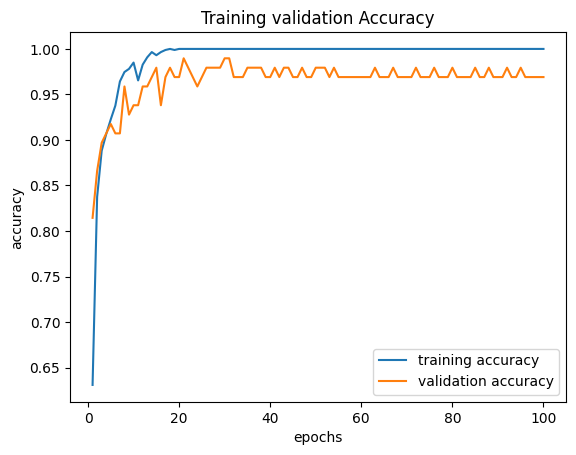

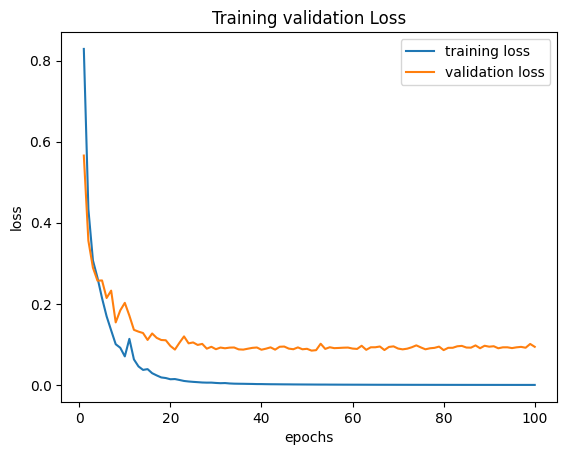

8/8 [==============================] - 0s 2ms/step
Confusion Matrix:
 [[75  0  6]
 [ 1 74  6]
 [ 1  3 76]]

Accuracy Score: 92.98%

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95        81
           1       0.96      0.91      0.94        81
           2       0.86      0.95      0.90        80

    accuracy                           0.93       242
   macro avg       0.93      0.93      0.93       242
weighted avg       0.93      0.93      0.93       242

Cohen's Kappa Score: 0.8946


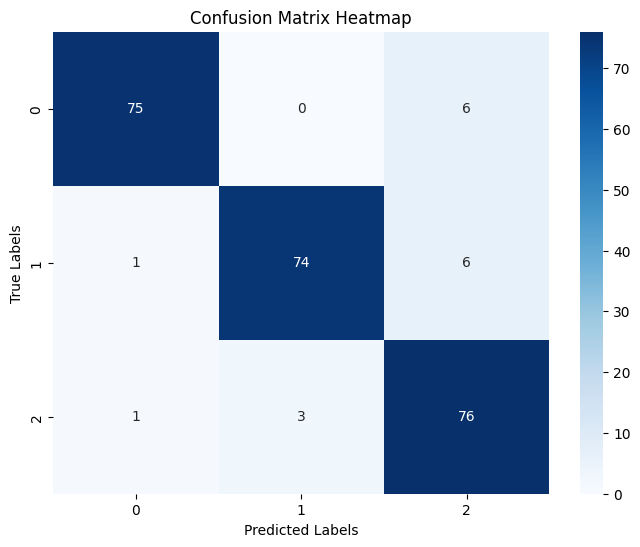

In [8]:

if __name__ == "__main__":
    # Step 6: Load your dataset
    # Load training data
    train_directory = os.path.join('..', 'Dataset', 'data', 'train')
    train_dataset = load_dataset_from_directory(train_directory)
    
    # Extract images and labels from the dataset
    images = []
    labels = []
    
    for batch in train_dataset:
        imgs, lbls = batch
        images.append(imgs.numpy())  # Convert to numpy arrays
        labels.append(lbls.numpy())
    
    # Convert lists to numpy arrays
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    print(f"Loaded {images.shape[0]} images of shape {images.shape[1:]}")
    print(f"Loaded {labels.shape[0]} labels")

    # Step 7: CNN Model for feature extraction
    cnn_model = create_custom_cnn(input_shape=(128, 128, 3))
    cnn_model.summary()
    
    # Step 8: GLCM parameters
    distances = [1, 3, 5, 3, 1, 3, 5]
    angles = [0, 0, 0, np.pi/4, np.pi/2, np.pi/2, np.pi/2]

    # Step 9: Extract features and save to CSV
    output_csv = 'features.csv'
    #extract_features_and_save(images, labels, cnn_model, output_csv, distances, angles)

    # Step 10: Load CSV and prepare for ANN training
    data = pd.read_csv(output_csv)
    X = data.iloc[:, :-1].values  # All columns except the last one (features)
    y = data.iloc[:, -1].values  # Last column (labels)
    
    # One-hot encode labels for multi-class classification
    y = tf.keras.utils.to_categorical(y, num_classes=3)
    
    # Preprocessing: Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"X_train.shape[1] : {X_train.shape[1]}")
    
    # Step 11: Create and train ANN
    ann_model = create_ann_model(input_dim=X_train.shape[1])
    ann_model.summary()
    
    history = ann_model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1)
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.plot(epochs, acc, label='training accuracy')
    plt.plot(epochs, val_acc, label='validation accuracy')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('Training validation Accuracy')
    plt.show()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Training validation Loss')
    plt.show()

    # Step 12: Evaluate the model
    evaluate_model(ann_model, X_test, y_test)